# Test data iterator with data augmentation

In [1]:
# https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2

import matplotlib.pylab as plt
%matplotlib inline

In [3]:
import sys
sys.path.append('../common')

In [4]:
from data_utils import type_1_ids, type_2_ids, type_3_ids, test_ids
from training_utils import get_trainval_id_type_lists, get_test_id_type_list, data_iterator
from training_utils import data_augmentation
from metrics import logloss_mc

Using Theano backend.


In [5]:
train_id_type_list, _ = get_trainval_id_type_lists()

image_size = (224, 224)
batch_size = 5
train_iter = data_iterator(train_id_type_list, 
                           batch_size=batch_size, 
                           image_size=image_size, 
                           data_augmentation_fn=lambda X, Y: data_augmentation(X, Y),
                           verbose=1, 
                           test_mode=False)

Train dataset contains : 
('-', [175, 546, 315], ' images of corresponding types')
Validation dataset contains : 
('-', [75, 234, 135], ' images of corresponding types')


((5, 3, 224, 224), dtype('float32'), (5, 3))


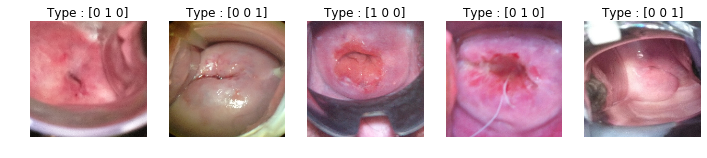

In [53]:
for X, Y in train_iter:
    print(X.shape, X.dtype, Y.shape)
    n = 5
    for counter in range(batch_size):
        if counter % n == 0:
            plt.figure(figsize=(12, 4))
        plt.subplot(1, n, counter % n + 1)
        plt.imshow(X[counter, :, :, :].transpose([1, 2, 0]))
        plt.title("Type : {}".format(Y[counter,:]))
        plt.axis('off')
    
    break

In [54]:
train_id_type_list, _ = get_trainval_id_type_lists()

image_size = (224, 224)
batch_size = 5
train_iter = data_iterator(train_id_type_list, 
                           batch_size=batch_size, 
                           image_size=image_size, 
                           data_augmentation_fn=lambda X, Y: data_augmentation(X, Y),
                           verbose=1, 
                           test_mode=True)

Train dataset contains : 
('-', [175, 546, 315], ' images of corresponding types')
Validation dataset contains : 
('-', [75, 234, 135], ' images of corresponding types')


('Image id/type:', '1011', 'Type_2', '| counter=', 0)
('Image id/type:', '1028', 'Type_3', '| counter=', 1)
('Image id/type:', '1027', 'Type_1', '| counter=', 2)
('Image id/type:', '1012', 'Type_2', '| counter=', 3)
('Image id/type:', '1029', 'Type_3', '| counter=', 4)
((5, 3, 224, 224), dtype('float32'), (5, 3))


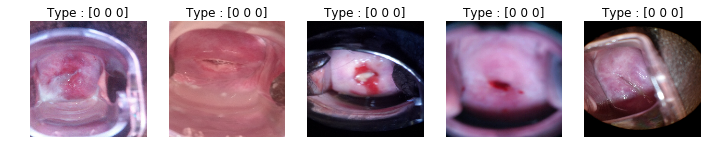

In [60]:
for X, Y, _ in train_iter:
    print(X.shape, X.dtype, Y.shape)
    n = 5
    for counter in range(batch_size):
        if counter % n == 0:
            plt.figure(figsize=(12, 4))
        plt.subplot(1, n, counter % n + 1)
        plt.imshow(X[counter, :, :, :].transpose([1, 2, 0]))
        plt.title("Type : {}".format(Y[counter,:]))
        plt.axis('off')
    
    break

Keras Segmentation Task Image Generator




In [5]:
import os
import numpy as np
np.random.seed(2017)

from data_utils import RESOURCES_PATH, GENERATED_DATA, get_annotations
from training_utils import get_trainval_id_type_lists2
sloth_annotations_filename = os.path.join(RESOURCES_PATH, 'cervix_os.json')
annotations = get_annotations(sloth_annotations_filename)

train_id_type_list, val_id_type_list = get_trainval_id_type_lists2(annotations=annotations, val_split=0.25)

print "Total : %s, Train : %s, Val : %s" % (len(annotations), len(train_id_type_list), len(val_id_type_list))

Total : 208, Train : 156, Val : 52


In [6]:
from keras.preprocessing.image import ImageDataGenerator, Iterator
from keras import backend as K

class XYIterator(Iterator):
    """
    Generate minibatches of image and mask
    
    :param xy_provider: generator function that provides image and mask with `yield`, e.g. `yield X, Y`. 
    Optionally, `xy_provider` can yield (x, y, additional_info), for example if some data id is need to be provided.
    Provided X, Y data should be 3D ndarrays of shape corresponding to `data_format`.
    See example below.
    :param n: total number of samples (images and masks) provided by `xy_provider`
    :param image_data_generator: instance of ImageDataGenerator. 
    If None, class iterates over all provided data by minibatches. This option can be used in testing mode.
    Other parameters are inherited from keras.preprocessing.image.Iterator and NumpyArrayIterator
    
    Example, xy_provider
    ```
    def xy_provider(image_ids):        
        for image_id in image_ids:
            image = load_image(image_id)
            mask = load_mask(image_id)
            
            # Some custom preprocesssing: resize
            # ...
            
            yield image, mask                
            # Or optionally:
            yield image, mask, image_id
    ```    
    """
    def __init__(self, xy_provider, n, image_data_generator,
                 batch_size=32, shuffle=False, seed=None,
                 image_data_format=None,
                 save_to_dir=None, save_prefix='', save_format='npz'):
        
        super(XYIterator, self).__init__(n, batch_size, shuffle, seed)
        
        if image_data_format is None:
            if not hasattr(K, 'image_data_format') and hasattr(K, 'image_dim_ordering'):                
                image_data_format = "channels_last" if K.image_dim_ordering() == "tf" else "channels_first"

        self.image_data_format = image_data_format
        
        self.xy_provider = xy_provider
        self.image_data_generator = image_data_generator
        
        if image_data_generator is None:
            self._process = lambda img, mask: img, mask
        else:
            self._process = self.image_data_generator.process

    def _check_img_format(self, img):
        assert len(img.shape) == 3, "Image should be a 3D ndarray"
        channel_index = -1 if self.image_data_format == 'channels_last' else 0
        assert min(img.shape) == img.shape[channel_index], \
            "Wrong data format: image shape '{}' and data format '{}'".format(img.shape, self.image_data_format)
        
    def next(self):
        """For python 2.x.

        # Returns
            The next batch.
        """
        with self.lock:
            index_array, current_index, current_batch_size = next(self.index_generator)
        # The transformation of images is not under thread lock
        # so it can be done in parallel 
        print index_array, current_index, current_batch_size        
        ret = next(self.xy_provider)
        x, y, info = ret if len(ret) > 2 else (ret[0], ret[1], None)                
        self._check_img_format(x)
        self._check_img_format(y)   
        
        batch_x = np.zeros((current_batch_size,) + x.shape, dtype=K.floatx())
        batch_y = np.zeros((current_batch_size,) + y.shape, dtype=K.floatx())
        batch_x[0], batch_y[0] = self._process(x, y)
        
        for i, j in enumerate(index_array[1:]):
            ret = next(self.xy_provider)
            x, y, info = ret if len(ret) > 2 else (ret[0], ret[1], None)                
            self._check_img_format(x)
            self._check_img_format(y)
            batch_x[i+1], batch_y[i+1] = self._process(x, y)
                        
        return batch_x, batch_y
    


class ImageMaskGenerator(ImageDataGenerator):
    """
    Generate minibatches of image and mask with real-time data augmentation.
    
    :param pipeline: list of functions or str to specify transformations to apply on image and mask
    Other parameters are inherited from keras.preprocessing.image.ImageDataGenerator
    
    Method `flow` takes as input a `xy_provider` which provides x, y. See `XYIterator` for more details.

    Usage:
    ```
    gen = ImageMaskGenerator(pipeline=(custom_func, 'standardize'))
    ```
    
    """
    default_transformations = [
        'random_transform', 
        'standardize', 
        'random_rotation',
        'random_shift',
        'random_shear',
        'random_zoom', 
    ]
    
    def __init__(self, pipeline=('random_transform', 'standardize'), **kwargs):
        super(ImageMaskGenerator, self).__init__(**kwargs)        
        self._check_pipeline(pipeline)        
        self.pipeline = pipeline
        
    def _check_pipeline(self, pipeline):
        assert (isinstance(pipeline, list) or isinstance(pipeline, tuple)) and len(pipeline) > 1, \
                "Pipeline should be a non-empty list"
        for t in pipeline:
            if isinstance(t, str):
                assert t in ImageMaskGenerator.default_transformations, "Unknown transformation '%s' in the pipeline" % t
            else: 
                assert callable(t), "Transformation %s is not callable" % type(t)            
                
    def process(self, x, y):
        
        return x, y
    
    def flow_from_directory(self, *args, **kwargs):        
        raise NotImplemented("This method should not be called")

    def fit(self, *args, **kwargs):        
        raise NotImplemented("This method should not be called")        
        
    def flow(self, xy_provider, n_samples, **kwargs):
        """
        Method to iterate over x, y provided by `xy_provider`
        """
        return XYIterator(xy_provider, n_samples, self, **kwargs)

In [7]:
gen = ImageMaskGenerator()

In [8]:
#gen.flow_from_directory("test")

In [9]:
from image_utils import get_image_data

def xy_provider(image_id_type_list, image_size=(224, 224), verbose=0):    
    for i, (image_id, image_type) in enumerate(image_id_type_list):
        if verbose > 0:
            print("Image id/type:", image_id, image_type, "| counter=", counter)

        img = get_image_data(image_id, image_type)
        if img.dtype.kind is not 'u':
            if verbose > 0:
                print("Image is corrupted. Id/Type:", image_id, image_type)
            continue
        img = cv2.resize(img, dsize=image_size[::-1])
        img = img.transpose([2, 0, 1])
        img = img.astype(np.float32) / 255.0
        
        label = get_image_data(image_id + "_" + image_type, "label")
        label = cv2.resize(label, dsize=image_size[::-1])
        label = label.transpose([2, 0, 1])
        
        yield img, label

In [11]:
train_id_type_list[:10]

[(u'917', u'Type_1'),
 (u'1452', u'Type_2'),
 (u'171', u'Type_1'),
 (u'725', u'Type_1'),
 (u'1457', u'Type_2'),
 (u'267', u'Type_1'),
 (u'516', u'Type_1'),
 (u'1198', u'Type_2'),
 (u'1438', u'Type_2'),
 (u'1023', u'Type_1')]

In [ ]:
# Visual test of xy_provider
_gen = xy_provider(train_id_type_list)
n = 5
max_counter = 20
for x, y in _gen:
    print y.shape, y[0,:,:].max(), y[1,:,:].max()
    
#     if counter % n == 0:
#         plt.figure(figsize=(12, 4))
#     plt.subplot(2, n, counter % n + 1)
#     plt.imshow(x[:, :, :].transpose([1, 2, 0]))
#     plt.subplot(2, n, n + counter % n + 1)
#     plt.imshow(y[0, :, :], alpha=0.5)
#     plt.imshow(y[1, :, :], alpha=0.5)    
#     plt.axis('off')

    max_counter -= 1
    if counter == 0:
        break    

(2, 224, 224) 1 1
(2, 224, 224) 1 1
(2, 224, 224) 1 1
(2, 224, 224) 1 1
(2, 224, 224) 1 1
(2, 224, 224) 1 1
(2, 224, 224) 1 1
(2, 224, 224) 1 1


('len(train_id_type_list)=', 156)
[0 1 2 3 4 5 6 7 8 9] 0 10
(10, 3, 224, 224) (10, 2, 224, 224)
[10 11 12 13 14 15 16 17 18 19] 10 10
(10, 3, 224, 224) (10, 2, 224, 224)


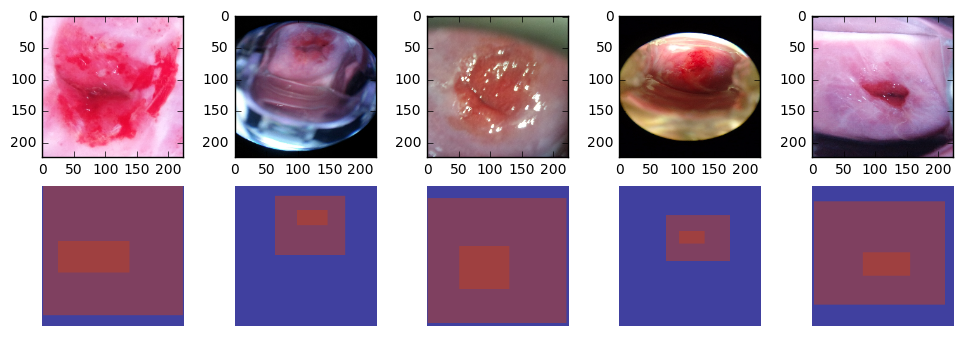

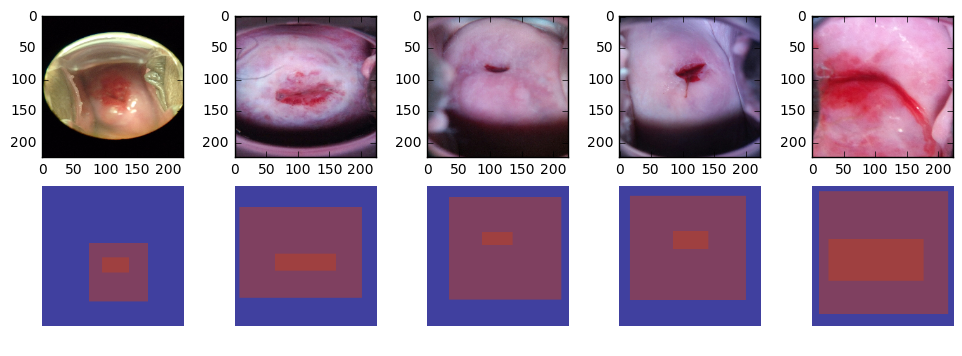

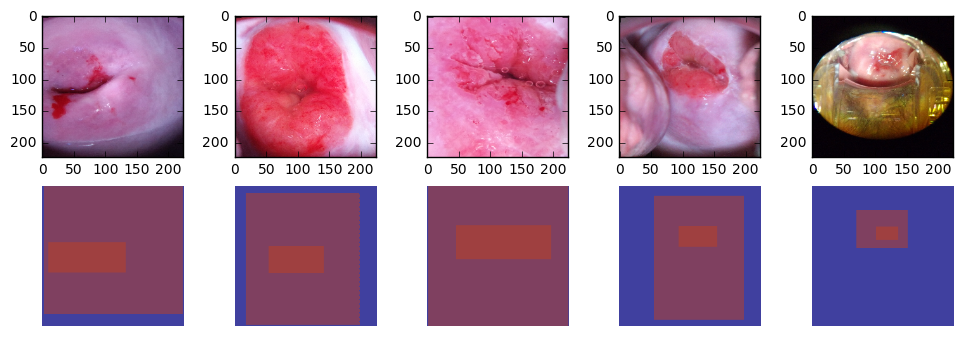

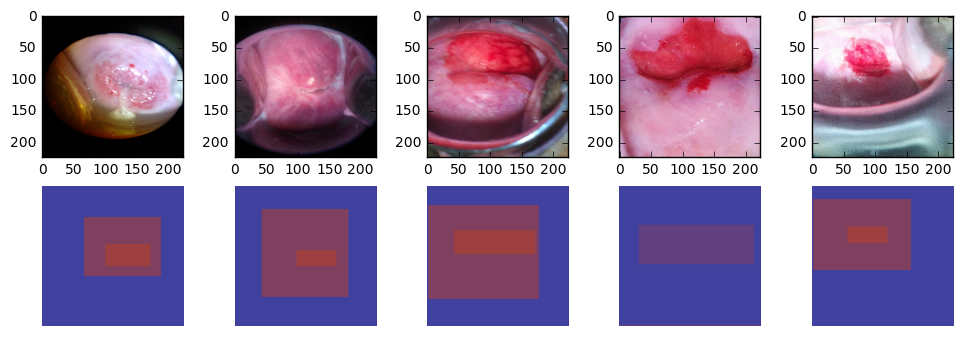

In [10]:
batch_size = 10
print("len(train_id_type_list)=", len(train_id_type_list))
loop_max_counter = 2
for x, y in gen.flow(xy_provider(train_id_type_list), len(train_id_type_list), batch_size=batch_size):
    print x.shape, y.shape   
    n = 5
    for counter in range(batch_size):
        if counter % n == 0:
            plt.figure(figsize=(12, 4))
        plt.subplot(2, n, counter % n + 1)
        plt.imshow(x[counter, :, :, :].transpose([1, 2, 0]))
        plt.subplot(2, n, n + counter % n + 1)
        plt.imshow(y[counter, 0, :, :], alpha=0.5)
        plt.imshow(y[counter, 1, :, :], alpha=0.5)    
        plt.axis('off')
    
    loop_max_counter -= 1
    if loop_max_counter == 0:
        break    

In [17]:
!ls /home/u2459/Intel_MobileODT/input/generated/labels/119

0_Type_1.npz	 1449_Type_2.npz  396_Type_1.npz  709_Type_1.npz
1013_Type_1.npz  144_Type_1.npz   401_Type_1.npz  710_Type_1.npz
1014_Type_1.npz  1450_Type_2.npz  41_Type_1.npz   713_Type_1.npz
1019_Type_1.npz  1451_Type_2.npz  421_Type_1.npz  725_Type_1.npz
1023_Type_1.npz  1452_Type_2.npz  425_Type_1.npz  727_Type_1.npz
102_Type_1.npz	 1453_Type_2.npz  441_Type_1.npz  732_Type_1.npz
104_Type_1.npz	 1454_Type_2.npz  446_Type_1.npz  739_Type_1.npz
109_Type_1.npz	 1457_Type_2.npz  454_Type_1.npz  745_Type_1.npz
10_Type_1.npz	 1480_Type_2.npz  469_Type_1.npz  751_Type_1.npz
1195_Type_2.npz  148_Type_1.npz   470_Type_1.npz  759_Type_1.npz
1196_Type_2.npz  14_Type_1.npz	  471_Type_1.npz  763_Type_1.npz
1197_Type_2.npz  160_Type_1.npz   47_Type_1.npz   764_Type_1.npz
1198_Type_2.npz  171_Type_1.npz   481_Type_1.npz  765_Type_1.npz
1201_Type_2.npz  176_Type_1.npz   484_Type_1.npz  769_Type_1.npz
1203_Type_2.npz  180_Type_1.npz   48_Type_1.npz   779_Type_1.npz
1205_Type_2.npz  181_Type_1.npz   